In [1]:
install.packages("tidyverse")
install.packages("tsibble")
install.packages("fable")
install.packages("fabletools")
install.packages("feasts")
install.packages("lubridate")
install.packages("scales")
install.packages("fpp3")
install.packages("gridExtra")
install.packages("tsibble")
install.packages("urca")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘Rcpp’, ‘BH’, ‘anytime’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘ggplot2’, ‘quadprog’, ‘progressr’, ‘ggdist’, ‘numDeriv’, ‘fabletools’, ‘distributional’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘warp’, ‘slider’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘tsibbledata’


Installing package into ‘/usr/local/lib/R/site-library

In [2]:
suppressMessages(library(tidyverse))
suppressMessages(library(tsibble))
suppressMessages(library(fable))
suppressMessages(library(tsibble))
suppressMessages(library(fabletools))
suppressMessages(library(feasts))
suppressMessages(library(lubridate))
suppressMessages(library(scales))
suppressMessages(library(fpp3))
suppressMessages(library(gridExtra))
suppressMessages(library(urca))

In [5]:
cpi <- read.csv('CPILFESL.csv')
cpi |> head(10)

,DATE,CPILFESL
,<chr>,<dbl>
1,1957-01-01,28.5
2,1957-02-01,28.6
3,1957-03-01,28.7
4,1957-04-01,28.8
5,1957-05-01,28.8
6,1957-06-01,28.9
7,1957-07-01,29.0
8,1957-08-01,29.0
9,1957-09-01,29.1


###Calculating the year-over-year percent change of CPI

In [6]:
cpi <- cpi |>
rename(CPI = CPILFESL) |>
mutate(CpiYOY = CPI/lag(CPI,n = 12)-1) |>
mutate(DATE = yearmonth(as.Date(DATE))) |>
filter(!is.na(CpiYOY)) %>%
as_tsibble(index = DATE)

cpi |> head(1)

DATE,CPI,CpiYOY
<mth>,<dbl>,<dbl>
1958 Jan,29.3,0.02807018


##Plotting the CPI series

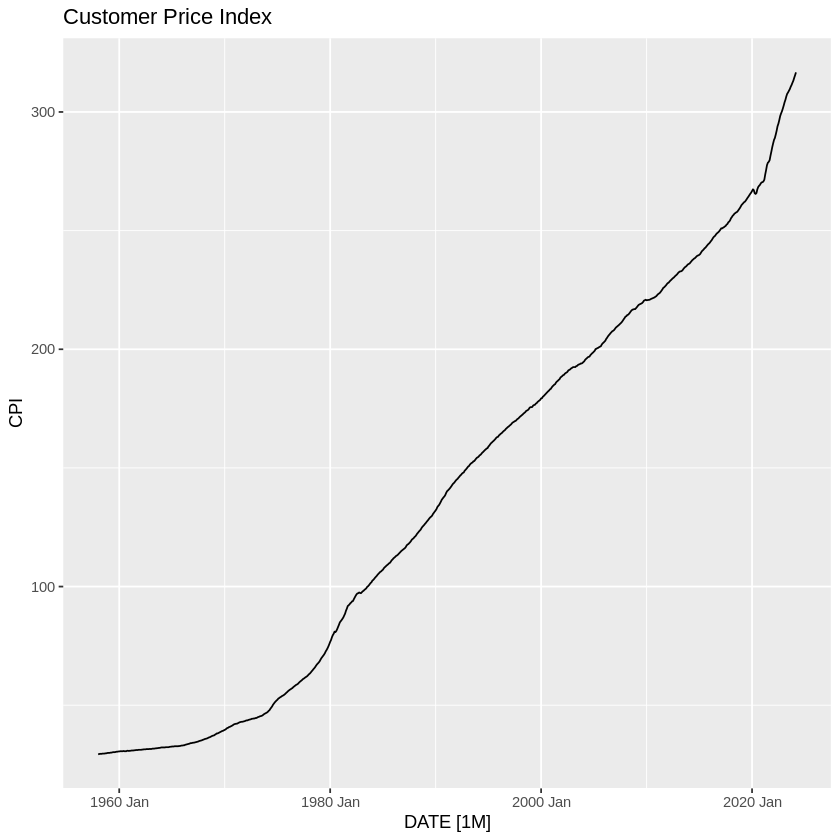

In [24]:
cpi |> autoplot(CPI) +
labs(title = 'Customer Price Index')

The series is exponential in nature.

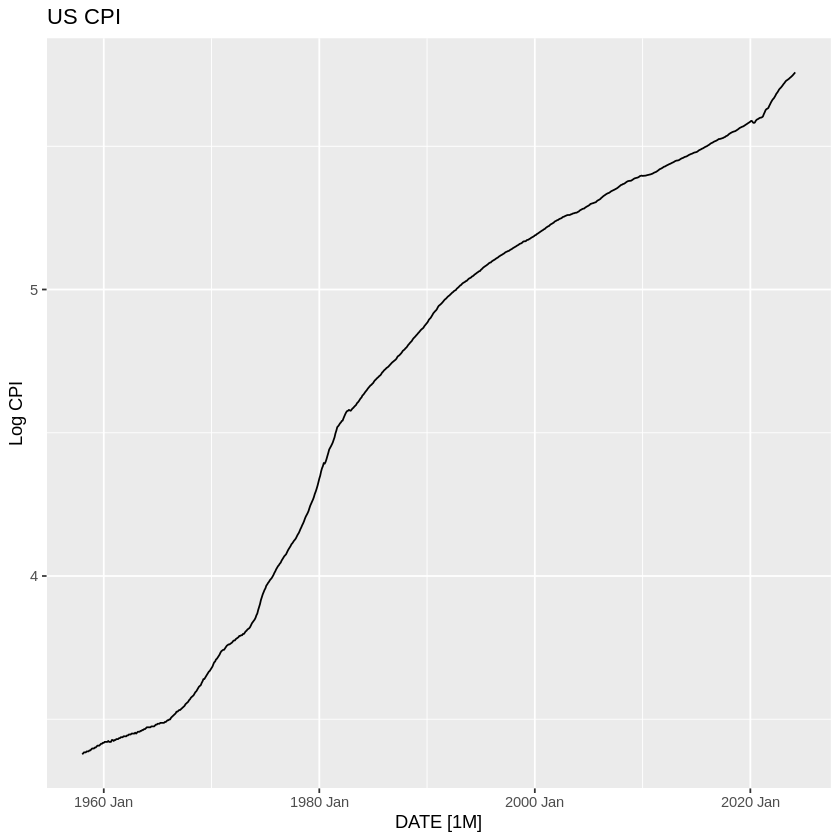

In [26]:
cpi %>% autoplot(log(CPI)) + labs(title='US CPI', y='Log CPI')

Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_line()`).”


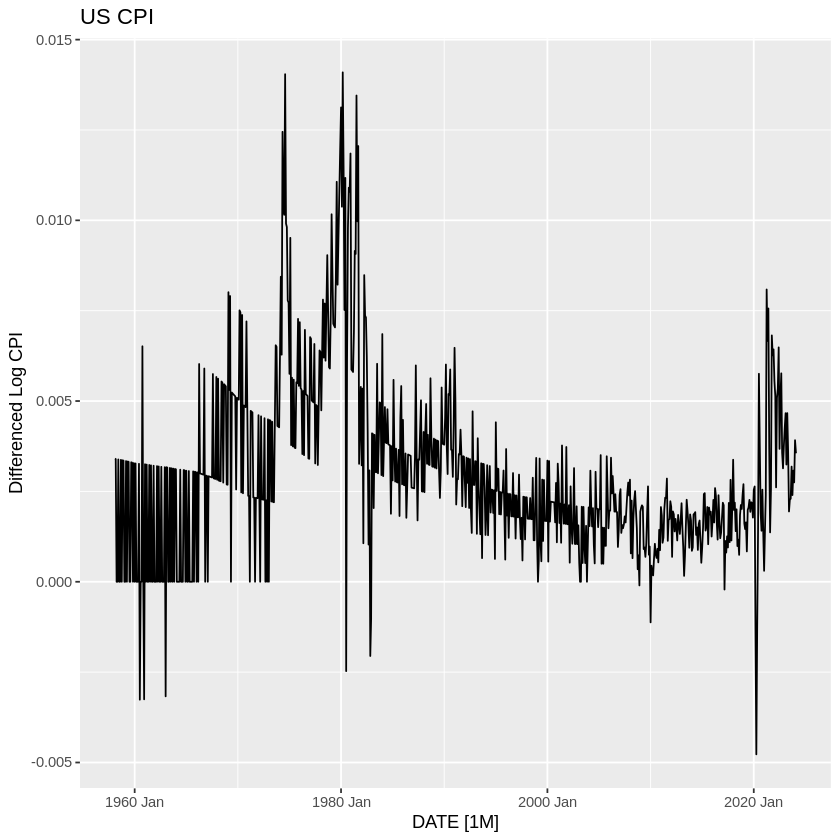

In [27]:
cpi %>% autoplot(difference(log(CPI))) + labs(title='US CPI', y='Differenced Log CPI/')

###Plotting CPI year over year change

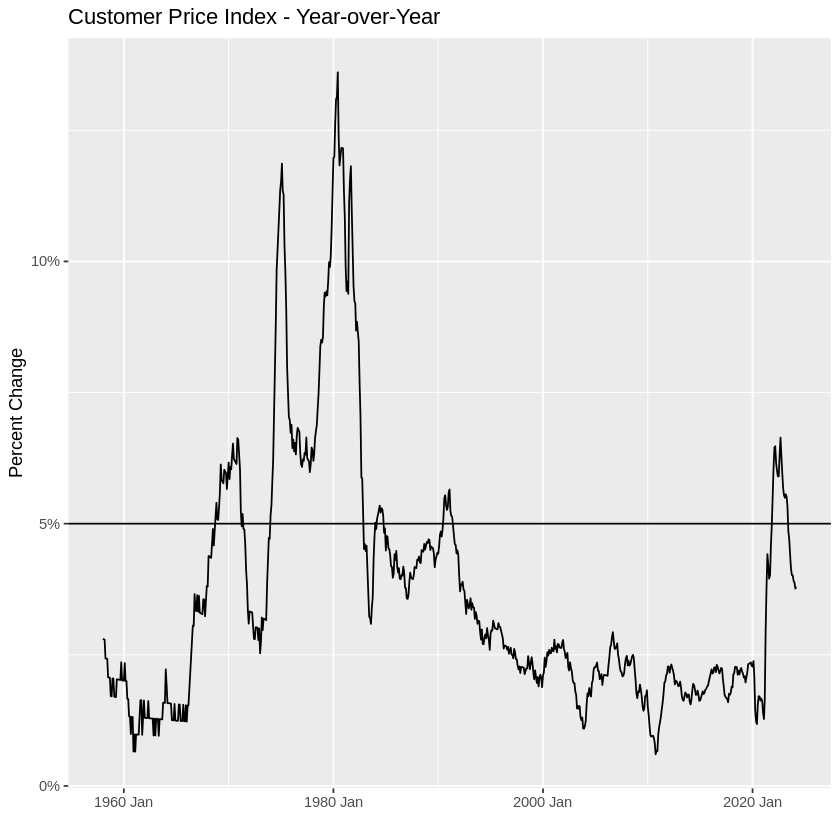

In [8]:
cpi |> autoplot(CpiYOY) +
labs(title = 'Customer Price Index - Year-over-Year', x='', y='Percent Change') +
scale_y_continuous(labels=scales::percent) +
geom_hline(yintercept = 0.05)

The plot looks pretty much like a stationary series.

In [9]:
cpi |> features(CpiYOY, unitroot_kpss)

kpss_stat,kpss_pvalue
<dbl>,<dbl>
2.159622,0.01


The value of kpss is 0.01, which means the series is not stationary

In [10]:
cpi %>% features(CpiYOY, unitroot_ndiffs)

ndiffs
<int>
1


The difference term(d) will be 1

Warning message in geom_line(...):
“Ignoring unknown parameters: `differences`”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_line()`).”


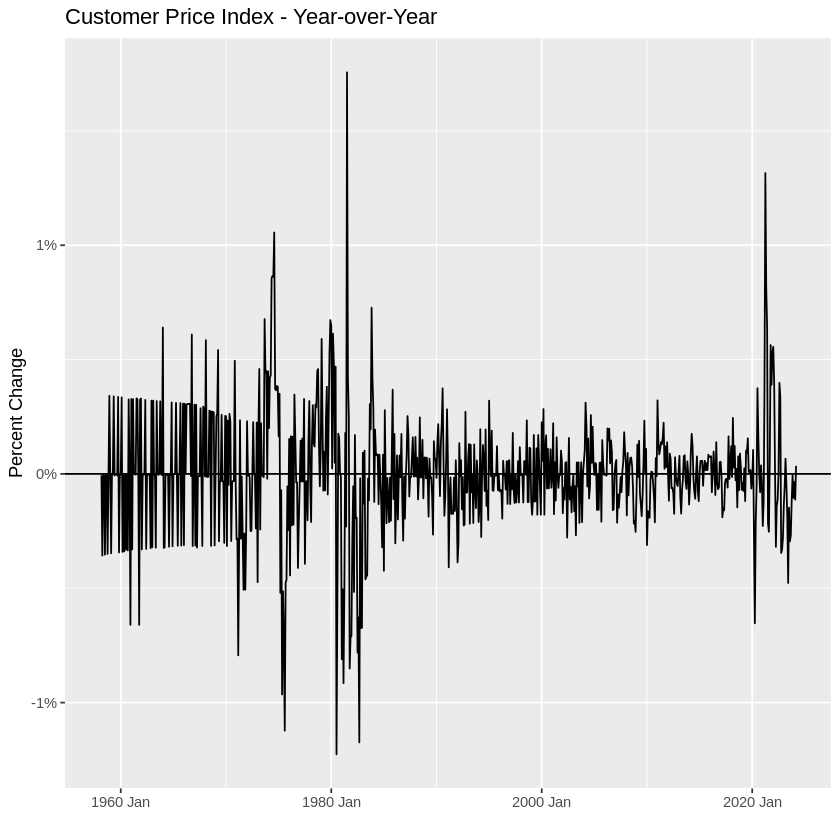

In [11]:
cpi |> autoplot(difference(CpiYOY), differences=1) +
labs(title = 'Customer Price Index - Year-over-Year', x='', y='Percent Change') +
scale_y_continuous(labels=scales::percent) +
geom_hline(yintercept = 0)

In [12]:
cpi |> features(difference(CpiYOY), unitroot_kpss)

kpss_stat,kpss_pvalue
<dbl>,<dbl>
0.05682118,0.1


The series is now stationary

##Determine the ARIMA Terms Based on ACF and PACF

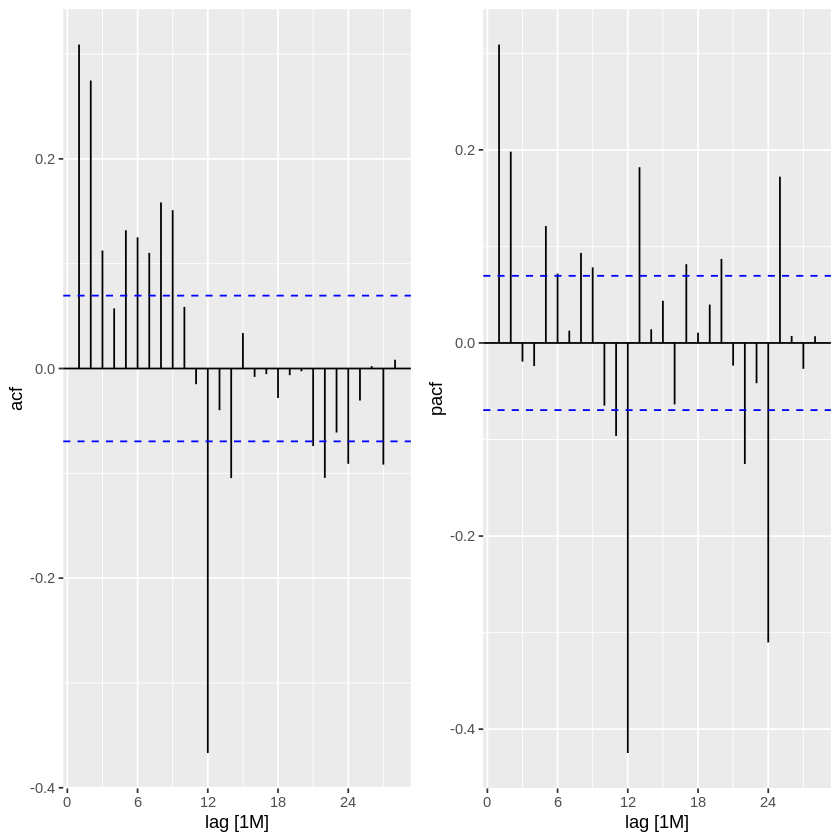

In [13]:
g1 <- cpi |> ACF(difference(CpiYOY)) |> autoplot()
g2 <- cpi |> PACF(difference(CpiYOY)) |> autoplot()

grid.arrange(g1, g2, ncol=2)

ARIMA(p,d,q), the p=2 because in the pacf because of significant spikes at lags 1 and 2.

q=3, because there are significant lags at the begining and lag 4 is within the interval.

So, the arima terms will be ARIMA(2,1,3)

###Splitting the data

In [14]:
cpi_tr <- cpi |> filter_index(. ~ 'Dec 2022')
cpi_ts <- cpi |> filter_index('Jan 2023' ~ .)

###Fitting the models

In [15]:
cpi_mdl <- cpi_tr |>
model(
    'ARIMA' = ARIMA(CpiYOY),
    'ETS' = ETS(CpiYOY),
    'Naive' = NAIVE(CpiYOY)
)

cpi_mdl |> select(ARIMA) |> report()

Series: CpiYOY 
Model: ARIMA(1,1,1)(2,0,2)[12] 

Coefficients:
         ar1      ma1    sar1     sar2     sma1    sma2
      0.9898  -0.7608  0.5776  -0.0771  -1.6567  0.6861
s.e.  0.0061   0.0261  0.1479   0.0473   0.1462  0.1430

sigma^2 estimated as 2.986e-06:  log likelihood=3837.1
AIC=-7660.19   AICc=-7660.05   BIC=-7627.59


Here, the ARIMA(1,1,1) shows the AR and MA terms are 1, which are very different from my conclusions above.

In [16]:
cpi_mdl  |> accuracy() |> select(.model, RMSE, MAPE)

.model,RMSE,MAPE
<chr>,<dbl>,<dbl>
ARIMA,0.001720252,4.258032
ETS,0.002465652,5.979368
Naive,0.002628524,5.770201


According to the errors, ARIMA has the lowest errors, hence it is the best model for further forecasting.

Residual analysis

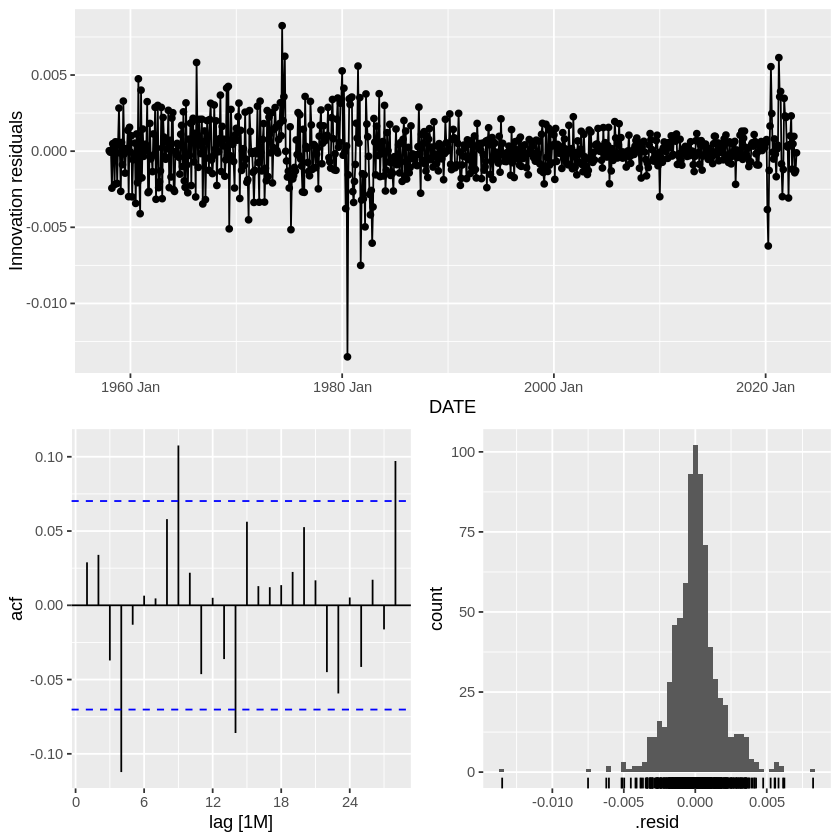

In [17]:
cpi_mdl |> select('ARIMA') |> gg_tsresiduals()

There are not many significant spikes in the ACF plots and it does not show any seasonality as well. The distribution also seems to be symmetric.

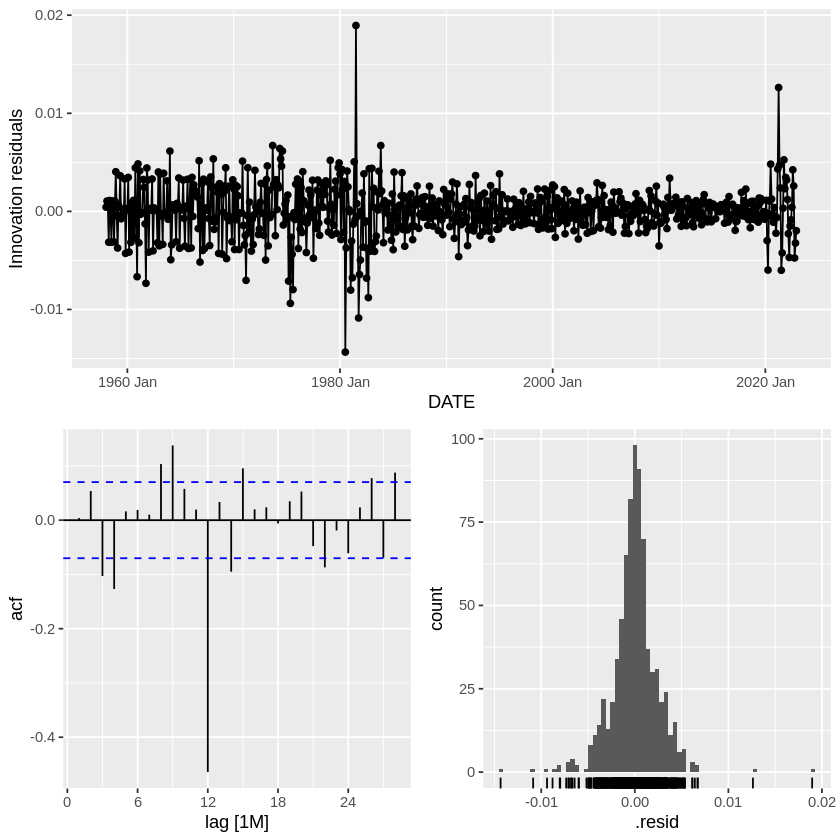

In [18]:
cpi_mdl |> select('ETS') |> gg_tsresiduals()

If looked closely, there are many spikes that go out of confidence intervals in the ETS model.

Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_line()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 1 row containing non-finite outside the scale range (`stat_bin()`).”


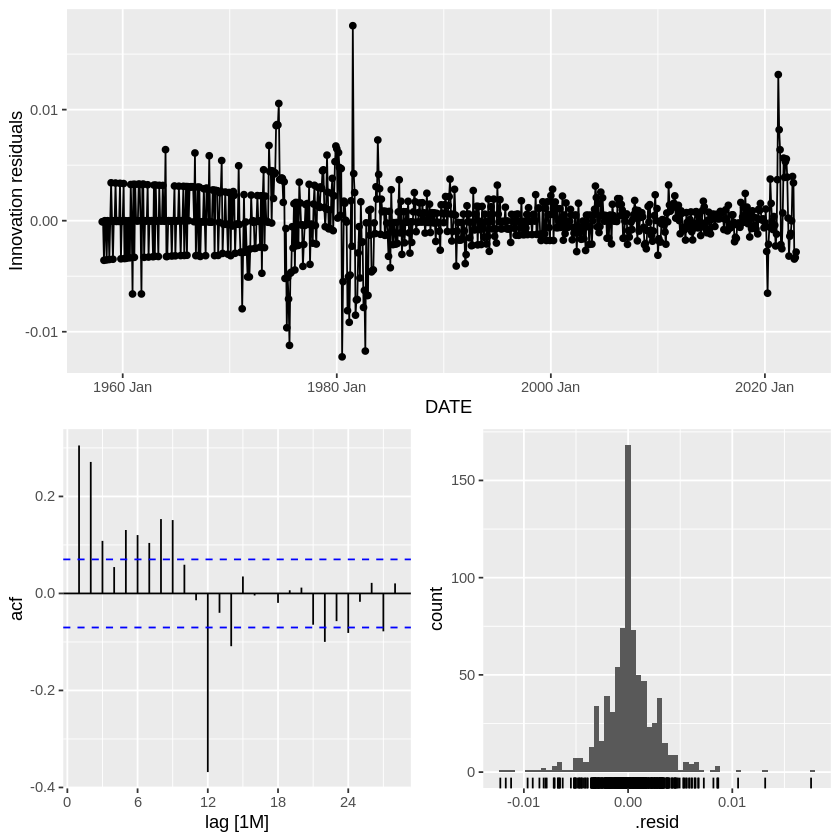

In [19]:
cpi_mdl |> select('Naive') |> gg_tsresiduals()

Naive model has a lot of correlations as there are many significant spikes in the ACF charts.

Out of the 3 models, ARIMA looks to be the best and according the MAPE and RMSE scores, I am choosing ARIMA to be the best model to further the forecast the series.

###Forecasts on test data

In [20]:
cpi_mdl_fcst <- cpi_mdl |>
forecast(cpi_ts)

cpi_mdl_fcst |> accuracy(cpi_ts) |> select(.model, RMSE, MAPE)

.model,RMSE,MAPE
<chr>,<dbl>,<dbl>
ARIMA,0.004952016,9.695664
ETS,0.008365816,16.721831
Naive,0.012899922,26.416666


For the test series as well, RMSE and MAPE scores, show that ARIMA has lowest errors.

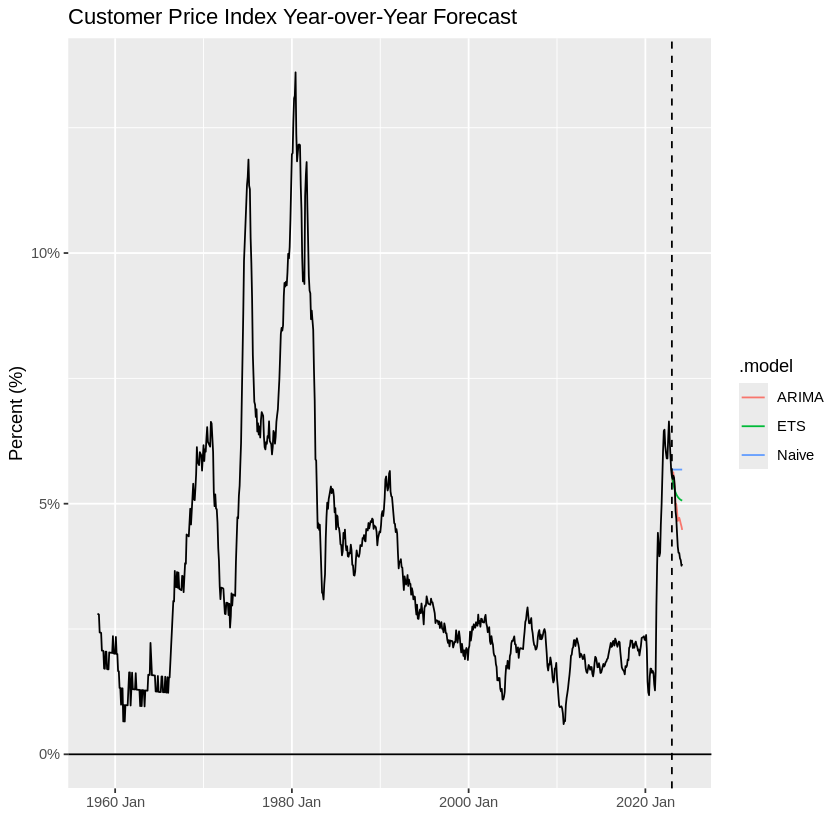

In [21]:
cpi_mdl_fcst |> autoplot(level=NULL) +
autolayer(cpi, CpiYOY) +
labs(title='Customer Price Index Year-over-Year Forecast', x='', y='Percent (%)') +
geom_vline(xintercept = as.Date('2023-01-01'), linetype='dashed') +
geom_hline(yintercept = 0) +
scale_y_continuous(labels=scales::percent)

The graph shows that ARIMA is fitting more closer to the data. Naive model does not perform well, ETS model comes close to fitting, but in overall sense, ARIMA performs better.

###Out of Sample Forecasts for next 12 months

In [22]:
cpi_mdl_fnl <- cpi |>
model(
    'ARIMA' = ARIMA(CpiYOY)
)

cpi_mdl_fnl %>% report()

Series: CpiYOY 
Model: ARIMA(1,1,1)(2,0,2)[12] 

Coefficients:
         ar1      ma1    sar1     sar2     sma1    sma2
      0.9888  -0.7594  0.5646  -0.0811  -1.6413  0.6708
s.e.  0.0060   0.0260  0.1463   0.0460   0.1447  0.1415

sigma^2 estimated as 2.943e-06:  log likelihood=3916.88
AIC=-7819.76   AICc=-7819.61   BIC=-7787.02


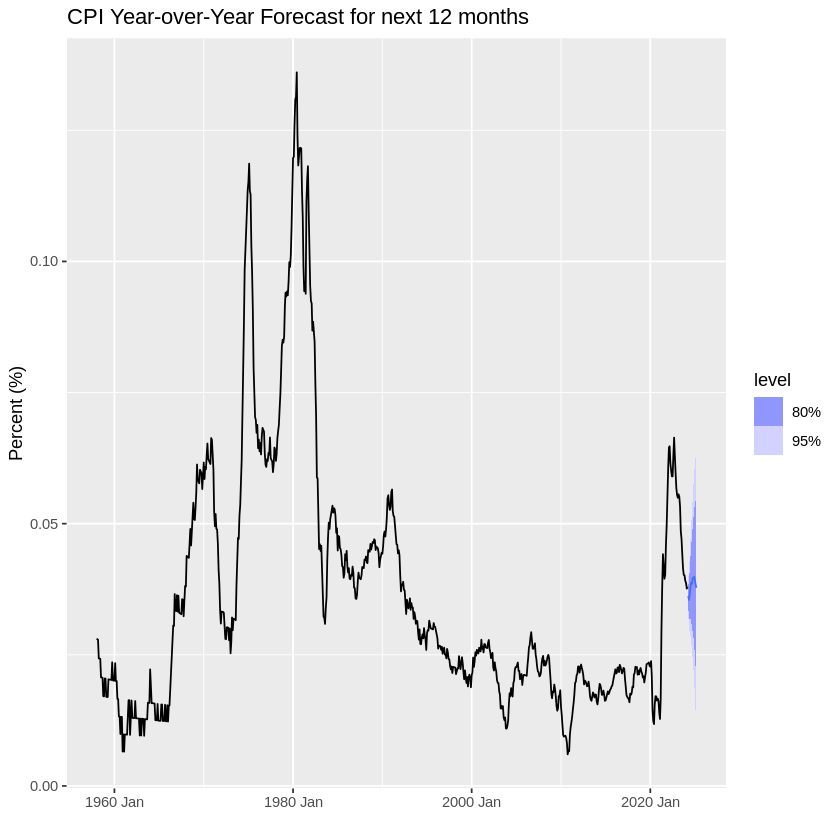

In [23]:
cpi_mdl_fnl |> forecast(h=12) |>
autoplot() +
autolayer(cpi, CpiYOY) +
labs(title='CPI Year-over-Year Forecast for next 12 months', x='', y='Percent (%)')

The CPI year over year percentage seems to be going a little up and then decreasing towards the end of the year.